## Compute lag features for gradient boosting model

In [536]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [464]:
colnames = ['id', 'ts', 'station_name', 'address', 'total_docks',
           'docks_in_service', 'available_docks', 'available_bikes',
           'percent_full', 'status', 'latitude', 'longitude', 'location', 'record']
docks_df = pd.read_csv('/Users/jordi/Downloads/chicago_docks.csv', names=colnames)

In [465]:
# drop unnecessary columns
docks_df = docks_df.drop(columns=['location', 'record'])

In [466]:
docks_df.head()

,id,ts,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,longitude
0,2,10/26/2018 11:55:13 AM,Buckingham Fountain,Buckingham Fountain,39,39,36,3,8,In Service,41.876470,-87.620340
1,3,10/26/2018 11:55:13 AM,Shedd Aquarium,Shedd Aquarium,55,54,50,4,7,In Service,41.867226,-87.615355
2,4,10/26/2018 11:55:13 AM,Burnham Harbor,Burnham Harbor,23,23,9,14,61,In Service,41.856268,-87.613348
3,5,10/26/2018 11:55:13 AM,State St & Harrison St,State St & Harrison St,23,22,20,2,9,In Service,41.874053,-87.627716
4,6,10/26/2018 11:55:13 AM,Dusable Harbor,Dusable Harbor,39,38,32,6,16,In Service,41.886976,-87.612813


In [467]:
docks_df.id.unique().shape

(615,)

In [468]:
stations_df = pd.read_csv('./datasets/chicago_stations.csv')

In [469]:
stations_df.head()

,Unnamed: 0,id,station_name,address,lat,lon
0,0,2,Buckingham Fountain,Buckingham Fountain,41.876470,-87.620340
1,1,3,Shedd Aquarium,Shedd Aquarium,41.867226,-87.615355
2,2,4,Burnham Harbor,Burnham Harbor,41.856268,-87.613348
3,3,5,State St & Harrison St,State St & Harrison St,41.874053,-87.627716
4,4,6,Dusable Harbor,Dusable Harbor,41.886976,-87.612813


In [470]:
stations_df.id.unique().shape

(615,)

In [471]:
station_ids = stations_df.id.unique()

## Preprocess at station level

In [859]:
station_id = station_ids[200]
df = docks_df[docks_df.id == station_id]
df['ts'] = pd.to_datetime(df.ts, infer_datetime_format=True)

In [860]:
df.ts.min(), df.ts.max()

(Timestamp('2017-01-01 00:05:11'), Timestamp('2018-10-26 11:55:13'))

In [861]:
# round ts every 5 minutes (seconds are not aligned)
df.loc[:, 'ts'] = df.ts.dt.round('5min')
df.sort_values(by='ts', inplace=True)

In [862]:
# resample data, there are missing info gaps
df = df.set_index('ts').resample('10Min', how='last', base=5).bfill()

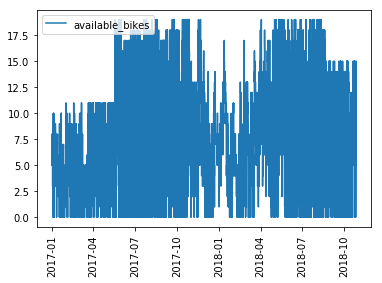

In [863]:
plt.plot(df.index, df.available_bikes, label='available_bikes')
plt.xticks(rotation=90)
plt.legend()

In [864]:
# every hour we have 6 rows, one every 10 minutes
entries_per_hour = 6

In [865]:
# month of year
df['month'] = df.index.month
# quarter of year
df['quarter'] = df.index.quarter
# day of month
df['day'] = df.index.day
# hour of day
df['hour'] = df.index.hour
# cyclic features for hour
df['hour_x'] = np.sin(2*np.pi*df['hour']/24)
df['hour_y'] = np.cos(2*np.pi*df['hour']/24)
# quarter of hour
df['quarter_hour'] = np.floor(df.index.minute / 15)
# day of week
df['dow'] = df.index.dayofweek
# week of year
df['week'] = df.index.weekofyear

In [866]:
ab_daily_mean = df.groupby('day')['available_bikes'].mean()
ab_monthly_mean = df.groupby('month')['available_bikes'].mean()
ab_weekly_mean = df.groupby('week')['available_bikes'].mean()

ab_daily_median = df.groupby('day')['available_bikes'].median()
ab_monthly_median = df.groupby('month')['available_bikes'].median()
ab_weekly_median = df.groupby('week')['available_bikes'].median()

In [867]:
for i, x in zip(ab_daily_mean.index, ab_daily_mean):
    df.loc[df.day == i, 'ab_daily_mean'] = x
    
for i, x in zip(ab_monthly_mean.index, ab_monthly_mean):
    df.loc[df.month == i, 'ab_monthly_mean'] = x
    
for i, x in zip(ab_weekly_mean.index, ab_weekly_mean):
    df.loc[df.week == i, 'ab_weekly_mean'] = x
    
for i, x in zip(ab_daily_median.index, ab_daily_median):
    df.loc[df.day == i, 'ab_daily_median'] = x
    
for i, x in zip(ab_monthly_median.index, ab_monthly_median):
    df.loc[df.month == i, 'ab_monthly_median'] = x
    
for i, x in zip(ab_weekly_median.index, ab_weekly_median):
    df.loc[df.week == i, 'ab_weekly_median'] = x

In [868]:
last_1w_hourly_mean = df.shift(entries_per_hour*24*7 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_1w_daily_mean = df.shift(entries_per_hour*24*7 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()
last_2w_hourly_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour)['available_bikes'].rolling(entries_per_hour).mean()
last_2w_daily_mean = df.shift(entries_per_hour*24*7*2 - entries_per_hour*24)['available_bikes'].rolling(entries_per_hour*24).mean()

In [869]:
df['last_1w_hourly_mean'] = last_1w_hourly_mean
df['last_1w_daily_mean'] = last_1w_daily_mean
df['last_2w_hourly_mean'] = last_2w_hourly_mean
df['last_2w_daily_mean'] = last_2w_daily_mean

In [870]:
# set status to unknown when status is not available
df.loc[pd.isna(df.status), 'status'] = 'Unknown'

In [871]:
df.columns

Index(['id', 'station_name', 'address', 'total_docks', 'docks_in_service',
       'available_docks', 'available_bikes', 'percent_full', 'status',
       'latitude', 'longitude', 'month', 'quarter', 'day', 'hour', 'hour_x',
       'hour_y', 'quarter_hour', 'dow', 'week', 'ab_daily_mean',
       'ab_monthly_mean', 'ab_weekly_mean', 'ab_daily_median',
       'ab_monthly_median', 'ab_weekly_median', 'last_1w_hourly_mean',
       'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean'],
      dtype='object')

### Set train/test splits

In [872]:
train_df = df.query('20170101 <= ts < 20180928')
# 2 weeks for validation
val_df = df.query('20180928 <= ts < 20181012')
# 2 weeks for test
test_df = df.query('ts >= 20181012')

In [873]:
train_df.shape, val_df.shape, test_df.shape

((91440, 30), (2016, 30), (2088, 30))

In [874]:
# overwrite last_1w_hourly_mean, last_1w_daily_mean columns for the second test week 
# this info is not available at test time!
idx = test_df.shift(freq=datetime.timedelta(weeks=1))[:entries_per_hour*24*7].index
features = ['last_1w_hourly_mean', 'last_1w_daily_mean']
test_df.loc[idx, features] = test_df.loc[idx - datetime.timedelta(weeks=1), features]

In [875]:
# drop first 2 weeks in train, no info for last_1w/2w features
train_df = train_df.iloc[entries_per_hour*24*7*2:]

In [876]:
train_df.shape, val_df.shape, test_df.shape

((89424, 30), (2016, 30), (2088, 30))

In [877]:
train_df.index.min(), train_df.index.max(), val_df.index.min(), val_df.index.max(), test_df.index.min(), test_df.index.max()

(Timestamp('2017-01-15 00:05:00', freq='10T'),
 Timestamp('2018-09-27 23:55:00', freq='10T'),
 Timestamp('2018-09-28 00:05:00', freq='10T'),
 Timestamp('2018-10-11 23:55:00', freq='10T'),
 Timestamp('2018-10-12 00:05:00', freq='10T'),
 Timestamp('2018-10-26 11:55:00', freq='10T'))

In [878]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

xs_features = ['total_docks', 'docks_in_service', 'status', 'ab_daily_mean', 'ab_monthly_mean', 'ab_weekly_mean',
               'ab_daily_median', 'ab_monthly_median', 'ab_weekly_median', 'hour_x', 'hour_y',
              'month', 'quarter', 'day', 'hour', 'quarter_hour', 'dow', 'week', 'last_1w_hourly_mean',
              'last_1w_daily_mean', 'last_2w_hourly_mean', 'last_2w_daily_mean']
target = ['available_bikes']

le = LabelEncoder()
train_df['status'] = le.fit_transform(train_df['status'])
val_df['status'] = le.transform(val_df['status'])
test_df['status'] = le.transform(test_df['status'])

train_data = lgb.Dataset(train_df[xs_features], label=train_df[target],
                        feature_name=xs_features, categorical_feature=['status'])
val_data = lgb.Dataset(val_df[xs_features], label=val_df[target],
                      feature_name=xs_features, categorical_feature=['status'], reference=train_data)
test_data = lgb.Dataset(test_df[xs_features], label=test_df[target],
                       feature_name=xs_features, categorical_feature=['status'])

In [879]:
test_df.head()

,id,station_name,address,total_docks,docks_in_service,available_docks,available_bikes,percent_full,status,latitude,...,ab_daily_mean,ab_monthly_mean,ab_weekly_mean,ab_daily_median,ab_monthly_median,ab_weekly_median,last_1w_hourly_mean,last_1w_daily_mean,last_2w_hourly_mean,last_2w_daily_mean
ts,,,,,,,,,,,,,,,,,,,,,
2018-10-12 00:05:00,219.0,Damen Ave & Cortland St,Damen Ave & Cortland St,15.0,15.0,6.0,9.0,60.0,0,41.915972,...,7.944129,9.364676,7.869544,7.0,9.0,7.0,5.0,8.208333,14.0,8.194444
2018-10-12 00:15:00,219.0,Damen Ave & Cortland St,Damen Ave & Cortland St,15.0,15.0,6.0,9.0,60.0,0,41.915972,...,7.944129,9.364676,7.869544,7.0,9.0,7.0,5.0,8.270833,14.0,8.145833
2018-10-12 00:25:00,219.0,Damen Ave & Cortland St,Damen Ave & Cortland St,15.0,15.0,6.0,9.0,60.0,0,41.915972,...,7.944129,9.364676,7.869544,7.0,9.0,7.0,5.0,8.340278,14.0,8.097222
2018-10-12 00:35:00,219.0,Damen Ave & Cortland St,Damen Ave & Cortland St,15.0,15.0,6.0,9.0,60.0,0,41.915972,...,7.944129,9.364676,7.869544,7.0,9.0,7.0,5.0,8.409722,14.0,8.048611
2018-10-12 00:45:00,219.0,Damen Ave & Cortland St,Damen Ave & Cortland St,15.0,15.0,6.0,9.0,60.0,0,41.915972,...,7.944129,9.364676,7.869544,7.0,9.0,7.0,5.0,8.479167,14.0,8.000000


In [880]:
params = {
    'objective': 'regression_l2',
    'num_threds': 4,
    'max_depth': 5,
    'num_boost_rounds': 100,
    'bagging_fraction': 0.75,
    'bagging_freq': 3,
    'feature_fraction': 0.75
}
bst = lgb.train(params, train_data, valid_sets=[val_data, test_data], early_stopping_rounds=10)

[1]	valid_0's l2: 21.8738	valid_1's l2: 19.0249
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 21.3925	valid_1's l2: 18.4853
[3]	valid_0's l2: 21.5646	valid_1's l2: 18.264
[4]	valid_0's l2: 21.7492	valid_1's l2: 18.1617
[5]	valid_0's l2: 21.235	valid_1's l2: 17.7964
[6]	valid_0's l2: 20.4125	valid_1's l2: 16.9119
[7]	valid_0's l2: 19.7734	valid_1's l2: 16.438
[8]	valid_0's l2: 19.3489	valid_1's l2: 16.1562
[9]	valid_0's l2: 19.4508	valid_1's l2: 16.193
[10]	valid_0's l2: 19.1981	valid_1's l2: 15.8945
[11]	valid_0's l2: 19.0098	valid_1's l2: 15.8294
[12]	valid_0's l2: 19.0195	valid_1's l2: 15.7617
[13]	valid_0's l2: 19.1208	valid_1's l2: 15.3403
[14]	valid_0's l2: 19.6366	valid_1's l2: 14.7205
[15]	valid_0's l2: 19.6127	valid_1's l2: 14.6534
[16]	valid_0's l2: 19.4183	valid_1's l2: 14.6927
[17]	valid_0's l2: 19.3779	valid_1's l2: 14.6936
[18]	valid_0's l2: 19.2793	valid_1's l2: 14.7489
[19]	valid_0's l2: 19.3611	valid_1's l2: 14.7261
[20]	valid_0's l2: 1

In [881]:
y_true = test_df['available_bikes']
y_hat = bst.predict(test_df[xs_features], num_iteration=bst.best_iteration)

In [885]:
# rmse
np.sqrt(np.mean((y_true - y_hat)**2))

3.978622386886989

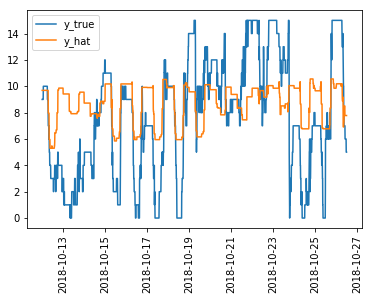

In [883]:
plt.plot(test_df.index, y_true, label='y_true')
plt.plot(test_df.index, y_hat, label='y_hat')
plt.xticks(rotation=90)
plt.legend()

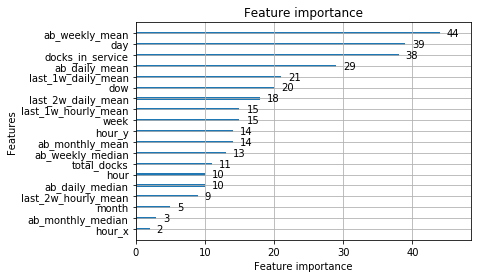

In [884]:
# plot feature importance
lgb.plot_importance(bst)

## TODO: Hyperparameter opt